In [2]:
#https://github.com/euphoris/datasets/raw/master/neurips.zip

'wget'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [4]:
import pandas as pd
df = pd.read_csv('../dataset/neurips.csv') # 압축안풀고 zip 파일 불러도 됨

In [5]:
df.head()

,year,title,abstract
0,2007,Competition Adds Complexity,It is known that determinining whether a DEC-P...
1,2007,Efficient Principled Learning of Thin Junction...,We present the first truly polynomial algorith...
2,2007,Regularized Boost for Semi-Supervised Learning,Semi-supervised inductive learning concerns ho...
3,2007,Simplified Rules and Theoretical Analysis for ...,We show that under suitable assumptions (prima...
4,2007,Predicting human gaze using low-level saliency...,"Under natural viewing conditions, human observ..."


In [6]:
df.tail()

,year,title,abstract
3915,2017,"On Separability of Loss Functions, and Revisit...",We revisit the classical analysis of generativ...
3916,2017,Maxing and Ranking with Few Assumptions,PAC maximum ...
3917,2017,On clustering network-valued data,"Community detection, which focuses on clusteri..."
3918,2017,A General Framework for Robust Interactive Lea...,We propose a general framework for interactive...
3919,2017,Multi-view Matrix Factorization for Linear Dyn...,We consider maximum likelihood estimation of l...


In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cv = TfidfVectorizer(stop_words='english', max_features=2000)

In [9]:
x = cv.fit_transform(df.abstract)

In [10]:
words = cv.get_feature_names()

## LSA 실습

In [11]:
from sklearn.decomposition import TruncatedSVD

In [12]:
x.shape

(3920, 2000)

In [13]:
svd = TruncatedSVD(n_components=100, random_state=1234)

In [14]:
svd.fit(x)

TruncatedSVD(n_components=100, random_state=1234)

In [21]:
word_idx = words.index('topic')

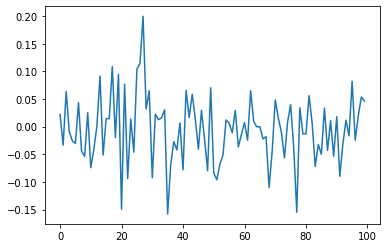

In [23]:
from matplotlib import pyplot
pyplot.plot(svd.components_[:, word_idx])

In [25]:
topic_idx = svd.components_[:, word_idx].argmax()
topic_idx

27

In [26]:
topic = pd.DataFrame({'word': words, 'loading': svd.components_[topic_idx]})
# 주제랑 단어의 관련도 : loading
topic.sort_values('loading').tail()

,word,loading
1202,norm,0.119621
804,graph,0.126101
866,image,0.155490
1861,topic,0.199617
1713,sparse,0.211411


## 병렬 분석을 통한 차원 크기 결정

In [28]:
import numpy as np

In [29]:
nrow, ncol = x.shape

In [30]:
def resample(a):
    return np.random.choice(a, size=nrow)

np.random.seed(2999)
d = np.apply_along_axis(resample, 0, x.A)

In [31]:
d.shape

(3920, 2000)

In [32]:
svd2 = TruncatedSVD(n_components=100, random_state=1234)
svd2.fit(d)

TruncatedSVD(n_components=100, random_state=1234)

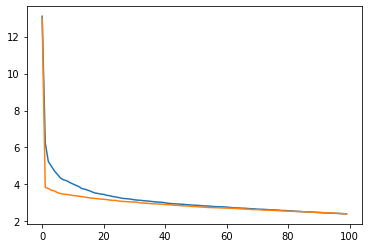

In [37]:
pyplot.plot(svd.singular_values_)
pyplot.plot(svd2.singular_values_)

In [42]:
np.argwhere(svd.singular_values_ - svd2.singular_values_ <= 0)[0]

array([89], dtype=int64)

In [44]:
svd.components_.shape

(100, 2000)

## 회전과 결과 해석

In [45]:
!pip install factor_analyzer

  Created wheel for factor-analyzer: filename=factor_analyzer-0.3.2-py3-none-any.whl size=40383 sha256=f6e98a699c31f693c3614c055f0d16c5b1c8900381785d062d32af3b1abe74b8
  Stored in directory: c:\users\leeji\appdata\local\pip\cache\wheels\b1\d4\b5\9da0e0e81266e87f5e85068f031077c8a2ae0eedf76ea1d294
Successfully built factor-analyzer


You should consider upgrading via the 'c:\users\leeji\anaconda3\python.exe -m pip install --upgrade pip' command.


In [46]:
from factor_analyzer.rotator import Rotator

In [47]:
rotator = Rotator()

In [48]:
rot = rotator.fit_transform(svd.components_.T)

In [49]:
rot.shape

(2000, 100)

In [50]:
loading = rot.T

In [64]:
word_idx = words.index('deep')

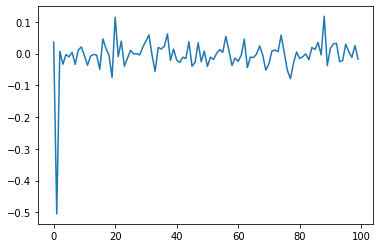

In [65]:
pyplot.plot(loading[:, word_idx])

In [67]:
topic_idx = loading[:, word_idx].argmin()
topic_idx

1

In [69]:
topic = pd.DataFrame({'word': words, 'loading': loading[topic_idx]})
# 주제랑 단어의 관련도 : loading
topic.sort_values('loading').head(10)

,word,loading
450,deep,-0.505157
1001,layer,-0.283529
1002,layers,-0.217273
1184,networks,-0.215860
397,convolutional,-0.190170
1185,neural,-0.165311
1483,recognition,-0.131614
1872,trained,-0.110204
105,architecture,-0.109013
106,architectures,-0.106676


In [57]:
doc_topics = svd.transform(x)

In [60]:
doc_topics = doc_topics @ rotator.rotation_

In [70]:
year_topic = pd.DataFrame({'year': df.year, 'topic': doc_topics[:, topic_idx]})

In [71]:
year_topic.groupby('year').agg('mean')

,topic
year,
2007,-0.016888
2008,-0.013269
2009,-0.013078
2010,-0.016361
2011,-0.009583
2012,-0.016532
2013,-0.016087
2014,-0.028141
2015,-0.031285


## NMF

In [72]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=89, random_state=1234)
# 차원에 따라 결과가 다르게 나옴
doc_topics = nmf.fit_transform(x)

C:\Users\leeji\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
C:\Users\leeji\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [73]:
loading = nmf.components_

In [79]:
word_idx = words.index('deep')

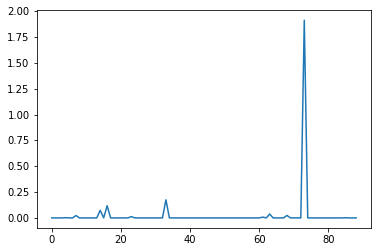

In [80]:
pyplot.plot(loading[:, word_idx])

In [81]:
topic_idx = loading[:, word_idx].argmax()
topic_idx

73

In [82]:
topic = pd.DataFrame({'word': words, 'loading': loading[topic_idx]})
topic.sort_values('loading').tail(10)

,word,loading
1872,trained,0.230900
1483,recognition,0.250119
834,hidden,0.260007
1541,representations,0.265281
397,convolutional,0.274323
106,architectures,0.329308
105,architecture,0.336127
1002,layers,0.707754
1001,layer,0.866000
450,deep,1.911767


In [83]:
year_topic = pd.DataFrame({'year': df.year, 'topic': doc_topics[:, topic_idx]})
year_topic.groupby('year').agg('mean')

,topic
year,
2007,0.004420
2008,0.001310
2009,0.002862
2010,0.003458
2011,0.002289
2012,0.003851
2013,0.003451
2014,0.006174
2015,0.007276
